In [1]:
import pandas as pd
import scipy.io
from os import listdir
from sklearn.utils import shuffle
from sklearn import preprocessing
#from nilearn import plotting
#from proteus.io import util
from proteus.visu import sbp_visu

import glob,os
#import nibabel as nib


import pickle
from proteus.predic import high_confidence_at
import numpy as np
import pandas as pd
from proteus.predic import prediction
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from copy import deepcopy

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

/home/angela/anaconda3/envs/vcog_paper_py35/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/angela/anaconda3/envs/vcog_paper_py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def stats_mask(y_true, y_pred, mask_selected=None):
    if mask_selected is None:
        mask_selected = np.ones(y_pred.shape).astype(bool)
    print('------------------------')
    print('Ratio:', y_true[mask_selected].sum()/y_true.sum()) 
    print('#    : ', y_true[mask_selected].sum()) 
    print('# true values: ',mask_selected.sum())
    print('ACC  : ', np.mean((y_true == y_pred)[mask_selected])) 

In [3]:
def predic_stats(y_, y_pred, lr_decision):
    # number of AD subjects
    n_ad = sum(y_)
    print('Total number of TARGET subjects: ', n_ad)

    # number of CN subjects
    n_cn = len(y_) - sum(y_)
    print('Total number of NON-TARGET subjects: ', n_cn)
    
    # number of subjects predicted as AD at stage 1
    n_pos = sum(y_pred)
    print('Stage 1 number of hits (true and false positives): ', n_pos)
    
    # true positives at stage 1
    n_pos_ad = sum(y_pred[y_.astype(bool)])
    print('Stage 1 TRUE positives: ', n_pos_ad)
    
    # false positives at stage 1
    n_pos_cn = n_pos - n_pos_ad
    print('Stage 1 FALSE positives: ', n_pos_cn)
    
    # number of CN subjects not identified as positive (true negatives)
    n_neg1_cn = n_cn - n_pos_cn
    print('Stage 1 TRUE negatives: ', n_neg1_cn)

    # number of all flagged HPC-AD subjects
    n_flag = sum(y_pred[lr_decision>0])
    print('Total number of flagged HPC-AD subjects: ', n_flag)

    # number of flagged HPC-AD subjects who are actually AD (true positives)
    y_pred_true = y_ + y_pred
    y_pred_true = y_pred_true==2
    n_flag_ad = sum(y_pred_true[lr_decision>0])
    print('Number of flagged HPC-AD subjects that are TRUE positives: ', n_flag_ad)

    # number of flagged HPC-AD subjects that are actually CN (false positives)
    n_flag_cn = n_flag - n_flag_ad
    print('Number of flagged HPC-AD subjects that are FALSE positives: ', n_flag_cn)

    # number of CN subjects that were not flagged (true negatives)
    n_neg_cn = n_cn - n_flag_cn
    print('Number of true negatives: ', n_neg_cn)
    
    print('#############################')
    print('Stage 1 stats for TARGET vs NON-TARGET')
    print('Precision for AD: ', n_pos_ad/(n_pos_ad + n_pos_cn))
    prec = n_pos_ad/(n_pos_ad + n_pos_cn)
    print('Recall (or sensitivity)  for AD: ', n_pos_ad/n_ad)
    sens = n_pos_ad/n_ad
    print('Specificity: ', n_neg1_cn/n_cn)
    spec = n_neg1_cn/n_cn
    fp = (1-spec)*664
    tp = sens*336
    adj_prec = tp/(tp+fp)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec)
    print('Accuracy: ', (n_pos_ad + n_neg1_cn)/(n_ad + n_cn))
    acc = (n_pos_ad + n_neg1_cn)/(n_ad + n_cn)

    print('#############################')
    print('Stage 2 stats for TARGET vs NON-TARGET')
    print('Precision for HPC-AD: ', n_flag_ad/n_flag)
    prec_2 = n_flag_ad/n_flag
    print('Recall (or sensitivity) for HPC-AD: ', n_flag_ad/n_ad)
    sens_2 = n_flag_ad/n_ad
    print('Specificity: ', n_neg_cn/n_cn)
    spec_2 = n_neg_cn/n_cn
    fp_2 = (1-spec_2)*664
    tp_2 = sens_2*336
    adj_prec_2 = tp_2/(tp_2 + fp_2)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec_2)
    print('Accuracy: ', (n_flag_ad + n_neg_cn)/(n_ad + n_cn))
    acc_2 = (n_flag_ad + n_neg_cn)/(n_ad + n_cn)
    
    return sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2

In [4]:
sns.set(font_scale=2)
sns.set_style("white")
#sns.set_context("paper")
#sns.set_palette("colorblind")
#sns.set_palette("GnBu_d")

#sns.set_palette(sns.cubehelix_palette(n_colors=8))
#sns.set_palette(sns.color_palette("BrBG", 6))

cpal = ["#F0DFB2", "#CFA255", "#995D12", "#B3E2DB", "#58B0A6", "#0D7068"]
sns.set_palette(cpal)


In [5]:
path_results = '/home/angela/Desktop/vcog_paper/gigascience/third_submission/roc/vbm/'

## Load longitudinal data 

In [6]:
np.random.seed(1)
#np.random.RandomState(1)

In [7]:
long_data = pd.read_csv('/home/angela/Documents/adni_csv/adnimerge_upenn_unw_av45_neurobat.csv')

/home/angela/anaconda3/envs/vcog_paper_py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load data for the training set (ADNI1)

In [8]:
data = pd.read_csv('/home/angela/Desktop/vcog_paper/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_model_weights.csv')

In [9]:
data.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv'],
            inplace=True)

# Organize the AD & CN data for classification task

In [10]:
# Mask of the CN and AD subjects only
mask_cnad = data.loc[:,['CN','AD']].values.sum(1).astype(bool)

In [11]:
#reload(high_confidence)
scalerX = preprocessing.StandardScaler()
scaler = preprocessing.StandardScaler()

x_ = data.iloc[mask_cnad,data.columns.get_loc("sub1"):data.columns.get_loc("sub7")+1].values
#x_ = scalerX.fit_transform(x_)
y_ = data[['AD']].values.ravel()[mask_cnad]

confounds = data[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_cnad,:]
#confounds[:, 1:] = scaler.fit_transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]

#crm = prediction.ConfoundsRm(confounds, x_)
#x_ = crm.transform(confounds, x_)

x_ = scaler.fit_transform(np.hstack((x_,confounds)))
#x_ = np.hstack((x_,confounds))


x_.shape, y_.shape, confounds.shape

((377, 11), (377,), (377, 4))

# Cross-validation HPC in ADNI1 AD & CN

In [12]:
scores_ad_cn=[]
scores_s2 = []
ad_precision = []
cn_precision = []
ad_recall = []
cn_recall = []
ad_f1_score = []
cn_f1_score = []

s1_spec = []
s1_sens = []
s1_prec = []
s1_acc = []

s2_spec = []
s2_sens = []
s2_prec = []
s2_acc = []


skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(x_,y_):
    X_training, X_val = x_[train_index], x_[val_index]
    y_training, y_val = y_[train_index], y_[val_index]
    
    hpc = high_confidence_at.TwoStagesPrediction(
        n_iter=500,
        shuffle_test_split=0.5,
        min_gamma=.99,
        thresh_ratio=0.1)
    
    hpc.fit(X_training, X_training, y_training)
    
    _, dic_results = hpc.predict(X_val, X_val)
    
    # test in validation sample
    acc = metrics.accuracy_score(y_val, (dic_results['s1df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2df'][:,1]>0)
    acc_s2 = metrics.accuracy_score(y_val[tmp_mask], (dic_results['s1df'][:,0]>0).astype(float)[tmp_mask])
    scores_ad_cn.append(acc)
    scores_s2.append(acc_s2)
    print('Classifying AD vs CN...')
    print((dic_results['s1df'][:,0]>0).astype(float))
    
    y_pred = (dic_results['s1df'][:,0]>0).astype(float)
    lr_decision = dic_results['s2df'][:,1]
    
    # BASE SVM PERFORMANCE
    ad_p = metrics.precision_score(y_val, y_pred)
    ad_precision.append(ad_p)
    cn_p = metrics.precision_score(y_val, y_pred, pos_label=0)
    cn_precision.append(cn_p)
    ad_r = metrics.recall_score(y_val, y_pred)
    ad_recall.append(ad_r)
    cn_r = metrics.recall_score(y_val, y_pred, pos_label=0)
    cn_recall.append(cn_r)
    ad_f1 = metrics.f1_score(y_val, y_pred)
    ad_f1_score.append(ad_f1)
    cn_f1 = metrics.f1_score(y_val, y_pred, pos_label=0)
    cn_f1_score.append(cn_f1)
    
    
    sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2 = predic_stats(y_val, y_pred, lr_decision)
    s1_spec.append(spec)
    s1_sens.append(sens)
    s1_prec.append(prec)
    s1_acc.append(acc)
    s2_spec.append(spec_2)
    s2_sens.append(sens_2)
    s2_prec.append(prec_2)
    s2_acc.append(acc_2)

Stage 1
Proba:
[0.9957265  1.         1.         1.         1.         0.65254237
 0.98380567 0.50746269 1.         1.         0.56818182 1.
 1.         1.         0.93589744 1.         0.99574468 0.71814672
 1.         1.         0.04918033 0.98333333 1.         0.88416988
 0.608      0.92828685 1.         1.         1.         1.
 0.996      0.99607843 1.         1.         1.         0.996139
 0.85470085 0.31746032 0.76377953 1.         1.         0.69635628
 1.         1.         1.         0.99607843 0.98297872 1.
 1.         1.         1.         0.56097561 0.         0.61111111
 1.         0.94466403 1.         0.99239544 0.98       1.
 0.99596774 1.         0.93495935 1.         1.         0.99193548
 1.         1.         0.96186441 0.85098039 1.         1.
 1.         0.63559322 1.         0.99618321 1.         1.
 1.         1.         0.94023904 1.         1.         0.89105058
 0.99595142 1.         0.         1.         1.         0.77205882
 1.         1.         0.01321

Proba:
[0.28688525 0.99603175 1.         1.         0.91153846 1.
 0.99579832 0.86521739 0.0112782  1.         0.28085106 0.9874477
 0.99590164 0.90114068 1.         0.8968254  1.         1.
 0.98846154 1.         1.         0.94117647 0.93951613 1.
 0.97482014 1.         0.         0.92857143 1.         0.
 1.         0.8559322  1.         0.21285141 1.         1.
 0.99206349 0.22222222 1.         1.         0.13114754 1.
 1.         0.9755102  1.         1.         0.99563319 1.
 0.         1.         1.         1.         0.98367347 1.
 0.05555556 0.94849785 0.01298701 0.99615385 0.14173228 0.3776824
 1.         0.40304183 1.         1.         0.90588235 1.
 1.         1.         1.         1.         0.96911197 0.91828794
 0.67424242 1.         0.64344262 0.89699571 1.         1.
 1.         1.         0.99625468 1.         1.         1.
 0.97540984 1.         0.26538462 0.58634538 1.         1.
 1.         0.76865672 0.65991903 0.66079295 1.         0.98319328
 1.         0.     

In [13]:
print('Stage 1')
print('Mean sensitivity: ', np.mean(s1_sens))
print('Mean specificity: ', np.mean(s1_spec))
print('Mean precision: ', np.mean(s1_prec))
print('Mean accuracy: ', np.mean(s1_acc))
print('#'*10)
print('Stage 2')
print('Mean sensitivity: ', np.mean(s2_sens))
print('Mean specificity: ', np.mean(s2_spec))
print('Mean precision: ', np.mean(s2_prec))
print('Mean accuracy: ', np.mean(s2_acc))

Stage 1
Mean sensitivity:  0.7962290784432344
Mean specificity:  0.8925120772946858
Mean precision:  0.8636936255983875
Mean accuracy:  0.8485879265091864
##########
Stage 2
Mean sensitivity:  0.5405323653962492
Mean specificity:  0.9560244387610117
Mean precision:  0.9125
Mean accuracy:  0.7664671916010498


# Train HPC (on whole training set of ADNI1 AD & CN)

In [14]:
#reload(high_confidence)
hpc = high_confidence_at.TwoStagesPrediction(
    n_iter=500,
    shuffle_test_split=0.5,
    min_gamma=.99,
    thresh_ratio=0.1)

hpc.fit(x_, x_, y_)

Stage 1
Proba:
[0.648      1.         1.         1.         0.99212598 1.
 1.         1.         0.         1.         0.26217228 1.
 1.         0.99588477 1.         1.         1.         1.
 1.         0.99628253 1.         1.         1.         1.
 1.         1.         0.         1.         1.         0.
 1.         0.7375     1.         0.54585153 1.         1.
 1.         0.1259542  1.         1.         0.16862745 1.
 1.         1.         1.         1.         0.97154472 1.
 0.         1.         1.         1.         1.         1.
 0.         1.         0.         0.99596774 0.29296875 0.3372093
 1.         0.97021277 1.         1.         0.9280303  1.
 1.         1.         1.         1.         0.87951807 0.856
 0.89112903 1.         0.67901235 0.93233083 1.         1.
 1.         1.         1.         1.         1.         1.
 0.9921875  1.         0.09745763 0.72962963 1.         1.
 1.         0.79400749 0.95850622 0.91304348 1.         1.
 1.         0.         1.      

In [15]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  172.0
# true values:  377
ACC  :  0.8647214854111406
Level 2
------------------------
Ratio: 0.622093023255814
#    :  107.0
# true values:  114
ACC  :  0.9385964912280702


In [16]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [17]:
print('Stage 1 stats for AD vs CN')
print(metrics.classification_report(y_, y_pred))

Stage 1 stats for AD vs CN
             precision    recall  f1-score   support

        0.0       0.85      0.91      0.88       205
        1.0       0.88      0.81      0.85       172

avg / total       0.87      0.86      0.86       377



In [18]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  172.0
Total number of NON-TARGET subjects:  205.0
Stage 1 number of hits (true and false positives):  159.0
Stage 1 TRUE positives:  140.0
Stage 1 FALSE positives:  19.0
Stage 1 TRUE negatives:  186.0
Total number of flagged HPC-AD subjects:  114.0
Number of flagged HPC-AD subjects that are TRUE positives:  107
Number of flagged HPC-AD subjects that are FALSE positives:  7.0
Number of true negatives:  198.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.8805031446540881
Recall (or sensitivity)  for AD:  0.813953488372093
Specificity:  0.9073170731707317
Adjusted precision for 33.6% baseline rate:  0.8163104986713116
Accuracy:  0.8647214854111406
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.9385964912280702
Recall (or sensitivity) for HPC-AD:  0.622093023255814
Specificity:  0.9658536585365853
Adjusted precision for 33.6% baseline rate:  0.9021427690114199
Accura

(0.813953488372093,
 0.9073170731707317,
 0.8805031446540881,
 0.8647214854111406,
 0.622093023255814,
 0.9658536585365853,
 0.9385964912280702,
 0.8090185676392573)

# compare with other methods 

## ROC curve

### base

In [19]:
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(377,)

In [20]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [21]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.91


### HPS

In [22]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [23]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [24]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.91


### rbf kernel svm

In [25]:
svm_param_grid=dict(C=(np.logspace(-2, 1, 15)))

clf_svm = SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovr', random_state=1)
grclf_svm = GridSearchCV(clf_svm, param_grid=svm_param_grid, 
                         cv=StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=1))               

grclf_svm.fit(x_, y_)
y_predicted = grclf_svm.predict(x_)
y_score = grclf_svm.decision_function(x_)
y_score.shape

(377,)

In [26]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_svcrbf = dict()
tpr_svcrbf = dict()
roc_auc_svcrbf = dict()
for i in range(n_classes):
    fpr_svcrbf[i], tpr_svcrbf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_svcrbf[i] = auc(fpr_svcrbf[i], tpr_svcrbf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_svcrbf["micro"], tpr_svcrbf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_svcrbf["micro"] = auc(fpr_svcrbf["micro"], tpr_svcrbf["micro"])

### k nearest neighbours

In [27]:
k_range = list(range(3,7))
weight_opt = ["uniform", "distance"]
knn_param_grid = dict(n_neighbors = k_range, weights = weight_opt)

clf_knn = KNeighborsClassifier(algorithm='auto')
grclf_knn = GridSearchCV(clf_knn, param_grid=knn_param_grid, 
                         cv=StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=1))
grclf_knn.fit(x_, y_)
y_predicted = grclf_knn.predict(x_)
#y_score = clf.decision_function(x_)
y_score = grclf_knn.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(377,)

In [28]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
# Compute micro-average ROC curve and ROC area
fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

### random forest

In [29]:
n_features = x_.shape[1]

In [30]:
rf_param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, n_features], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

clf_rf = RandomForestClassifier(random_state=1)
grclf_rf = GridSearchCV(clf_rf, param_grid=rf_param_grid, 
                       cv=StratifiedShuffleSplit(n_splits=50, test_size=.2, random_state=1))
grclf_rf.fit(x_, y_)
y_predicted = grclf_rf.predict(x_)
#y_score = clf.decision_function(x_)
y_score = grclf_rf.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(377,)

In [31]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

### gaussian naive bayes

In [32]:
clf_gnb = GaussianNB()
clf_gnb.fit(x_, y_)
y_predicted = clf_gnb.predict(x_)
#y_score = clf.decision_function(x_)
y_score = clf_gnb.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(377,)

In [33]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])
    
# Compute micro-average ROC curve and ROC area
fpr_nb["micro"], tpr_nb["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_nb["micro"] = auc(fpr_nb["micro"], tpr_nb["micro"])

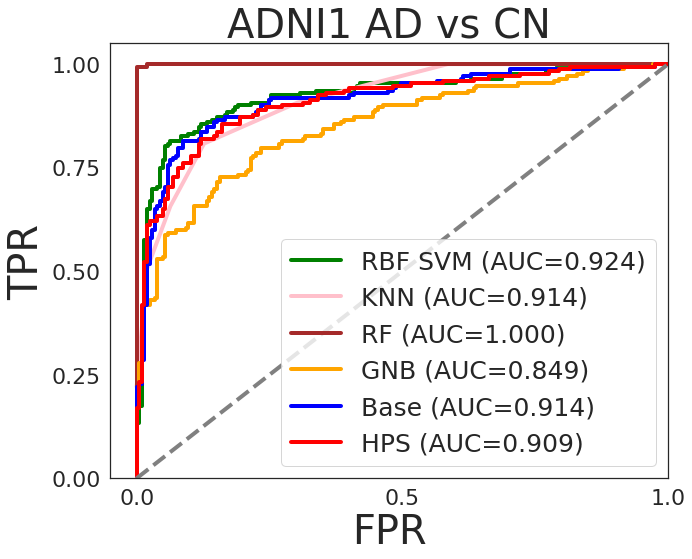

In [34]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
lw = 4
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.plot(fpr_svcrbf[0], tpr_svcrbf[0], color='green',
         lw=lw, label='RBF SVM (AUC=%0.3f)' % roc_auc_svcrbf[0])
plt.plot(fpr_knn[0], tpr_knn[0], color='pink',
         lw=lw, label='KNN (AUC=%0.3f)' % roc_auc_knn[0])
plt.plot(fpr_rf[0], tpr_rf[0], color='brown',
         lw=lw, label='RF (AUC=%0.3f)' % roc_auc_rf[0])
plt.plot(fpr_nb[0], tpr_nb[0], color='orange',
         lw=lw, label='GNB (AUC=%0.3f)' % roc_auc_nb[0])
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (AUC=%0.3f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (AUC=%0.3f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontdict={'size': 40})
plt.ylabel('TPR', fontdict={'size': 40})
plt.title('ADNI1 AD vs CN', fontdict={'size': 40})
plt.legend(loc="lower right", prop={'size': 25})
plt.show()
fig.savefig(path_results + 'adni1_ad_roc_multi.pdf', bbox_inches='tight')

## Test on ADNI1 MCI

In [35]:
# load the data
adni1_mci = pd.read_csv('/home/angela/Desktop/vcog_paper/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_mci_bl_demog_weights.csv')

In [36]:
mask_mci = adni1_mci.loc[:,'MCI'].values.astype(bool)
adni1_mci = adni1_mci.iloc[mask_mci]

In [37]:
adni1_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv'],inplace=True)

In [38]:
len(adni1_mci)

238

In [39]:
x_ = adni1_mci.iloc[:,adni1_mci.columns.get_loc("sub1"):adni1_mci.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni1_mci['conv_2_ad'].values.ravel()


confounds = adni1_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((238, 11), (238,), (238, 4))

In [40]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  149.0
# true values:  238
ACC  :  0.6890756302521008
Level 2
------------------------
Ratio: 0.42953020134228187
#    :  64.0
# true values:  73
ACC  :  0.8767123287671232


In [41]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [42]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  149.0
Total number of NON-TARGET subjects:  89.0
Stage 1 number of hits (true and false positives):  123.0
Stage 1 TRUE positives:  99.0
Stage 1 FALSE positives:  24.0
Stage 1 TRUE negatives:  65.0
Total number of flagged HPC-AD subjects:  73.0
Number of flagged HPC-AD subjects that are TRUE positives:  64
Number of flagged HPC-AD subjects that are FALSE positives:  9.0
Number of true negatives:  80.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.8048780487804879
Recall (or sensitivity)  for AD:  0.6644295302013423
Specificity:  0.7303370786516854
Adjusted precision for 33.6% baseline rate:  0.5549237482567817
Accuracy:  0.6890756302521008
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.8767123287671232
Recall (or sensitivity) for HPC-AD:  0.42953020134228187
Specificity:  0.898876404494382
Adjusted precision for 33.6% baseline rate:  0.6824767854850442
Accuracy: 

(0.6644295302013423,
 0.7303370786516854,
 0.8048780487804879,
 0.6890756302521008,
 0.42953020134228187,
 0.898876404494382,
 0.8767123287671232,
 0.6050420168067226)

## ROC curve 

### base

In [43]:
#base = high_confidence_at.BaseSvc()
#base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(238,)

In [44]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [45]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.84


### HPS 

In [46]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [47]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

### rbf kernel svm

In [48]:
y_predicted = grclf_svm.predict(x_)
y_score = grclf_svm.decision_function(x_)
y_score.shape

(238,)

In [49]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_svcrbf = dict()
tpr_svcrbf = dict()
roc_auc_svcrbf = dict()
for i in range(n_classes):
    fpr_svcrbf[i], tpr_svcrbf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_svcrbf[i] = auc(fpr_svcrbf[i], tpr_svcrbf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_svcrbf["micro"], tpr_svcrbf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_svcrbf["micro"] = auc(fpr_svcrbf["micro"], tpr_svcrbf["micro"])

### k nearest neighbours

In [50]:
y_predicted = grclf_knn.predict(x_)
y_score = grclf_knn.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(238,)

In [51]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
# Compute micro-average ROC curve and ROC area
fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

### random forest

In [52]:
y_predicted = grclf_rf.predict(x_)
y_score = grclf_rf.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(238,)

In [53]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

### gaussian naive bayes

In [54]:
y_predicted = clf_gnb.predict(x_)
y_score = clf_gnb.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(238,)

In [55]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])
    
# Compute micro-average ROC curve and ROC area
fpr_nb["micro"], tpr_nb["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_nb["micro"] = auc(fpr_nb["micro"], tpr_nb["micro"])

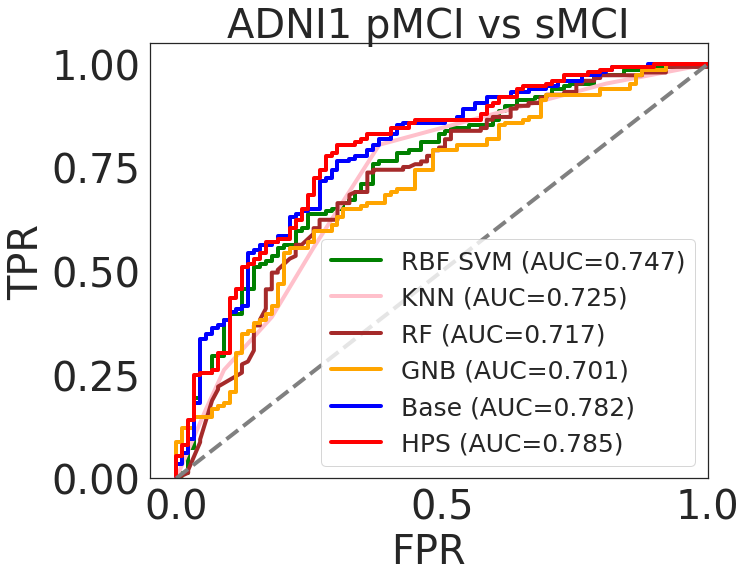

In [56]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
lw = 4
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.plot(fpr_svcrbf[0], tpr_svcrbf[0], color='green',
         lw=lw, label='RBF SVM (AUC=%0.3f)' % roc_auc_svcrbf[0])
plt.plot(fpr_knn[0], tpr_knn[0], color='pink',
         lw=lw, label='KNN (AUC=%0.3f)' % roc_auc_knn[0])
plt.plot(fpr_rf[0], tpr_rf[0], color='brown',
         lw=lw, label='RF (AUC=%0.3f)' % roc_auc_rf[0])
plt.plot(fpr_nb[0], tpr_nb[0], color='orange',
         lw=lw, label='GNB (AUC=%0.3f)' % roc_auc_nb[0])
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (AUC=%0.3f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (AUC=%0.3f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontdict={'size': 40})
plt.ylabel('TPR', fontdict={'size': 40})
plt.title('ADNI1 pMCI vs sMCI', fontdict={'size': 40})
plt.legend(loc="lower right", prop={'size': 25})
#ax.legend(loc='center left', bbox_to_anchor=(1,0.5), prop={'size': 30})
plt.show()
fig.savefig(path_results + 'adni1_mci_roc_multi.pdf', bbox_inches='tight')

# REPLICATION IN ADNI2 

In [57]:
adni2_df = pd.read_csv('/home/angela/Desktop/vcog_paper/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_model_weights.csv')

In [58]:
adni2_df.drop(adni2_df[adni2_df.RID < 2000].index,inplace=True)

In [59]:
# get rid of NaNs
adni2_df.dropna(axis=0,how='any',subset=['sub1','gender','age_scan','mean_gm','tiv','conv_2_ad'],inplace=True)

## AD vs CN 

In [60]:
# Mask of the AD and CN subjects only
mask_cnad = adni2_df.loc[:,['CN','AD']].values.sum(1).astype(bool)

x_ = adni2_df.iloc[mask_cnad,adni2_df.columns.get_loc("sub1"):adni2_df.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_df[['AD']].values.ravel()[mask_cnad]


confounds = adni2_df[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((278, 11), (278,), (278, 4))

In [61]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  90.0
# true values:  278
ACC  :  0.7230215827338129
Level 2
------------------------
Ratio: 0.3333333333333333
#    :  30.0
# true values:  46
ACC  :  0.6521739130434783


In [62]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [63]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  90.0
Total number of NON-TARGET subjects:  188.0
Stage 1 number of hits (true and false positives):  89.0
Stage 1 TRUE positives:  51.0
Stage 1 FALSE positives:  38.0
Stage 1 TRUE negatives:  150.0
Total number of flagged HPC-AD subjects:  46.0
Number of flagged HPC-AD subjects that are TRUE positives:  30
Number of flagged HPC-AD subjects that are FALSE positives:  16.0
Number of true negatives:  172.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.5730337078651685
Recall (or sensitivity)  for AD:  0.5666666666666667
Specificity:  0.7978723404255319
Adjusted precision for 33.6% baseline rate:  0.5865450159928688
Accuracy:  0.7230215827338129
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.6521739130434783
Recall (or sensitivity) for HPC-AD:  0.3333333333333333
Specificity:  0.9148936170212766
Adjusted precision for 33.6% baseline rate:  0.6646464646464647
Accuracy

(0.5666666666666667,
 0.7978723404255319,
 0.5730337078651685,
 0.7230215827338129,
 0.3333333333333333,
 0.9148936170212766,
 0.6521739130434783,
 0.7266187050359713)

## ROC curve

### base

In [64]:
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(278,)

In [65]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [66]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.56


### HPS 

In [67]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [68]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [69]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.52


### rbf kernel svm

In [70]:
y_predicted = grclf_svm.predict(x_)
y_score = grclf_svm.decision_function(x_)
y_score.shape

(278,)

In [71]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_svcrbf = dict()
tpr_svcrbf = dict()
roc_auc_svcrbf = dict()
for i in range(n_classes):
    fpr_svcrbf[i], tpr_svcrbf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_svcrbf[i] = auc(fpr_svcrbf[i], tpr_svcrbf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_svcrbf["micro"], tpr_svcrbf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_svcrbf["micro"] = auc(fpr_svcrbf["micro"], tpr_svcrbf["micro"])

### k nearest neighbours

In [72]:
y_predicted = grclf_knn.predict(x_)
y_score = grclf_knn.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(278,)

In [73]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
# Compute micro-average ROC curve and ROC area
fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

### random forest

In [74]:
y_predicted = grclf_rf.predict(x_)
y_score = grclf_rf.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(278,)

In [75]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

### gaussian naive bayes

In [76]:
y_predicted = clf_gnb.predict(x_)
y_score = clf_gnb.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(278,)

In [77]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])
    
# Compute micro-average ROC curve and ROC area
fpr_nb["micro"], tpr_nb["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_nb["micro"] = auc(fpr_nb["micro"], tpr_nb["micro"])

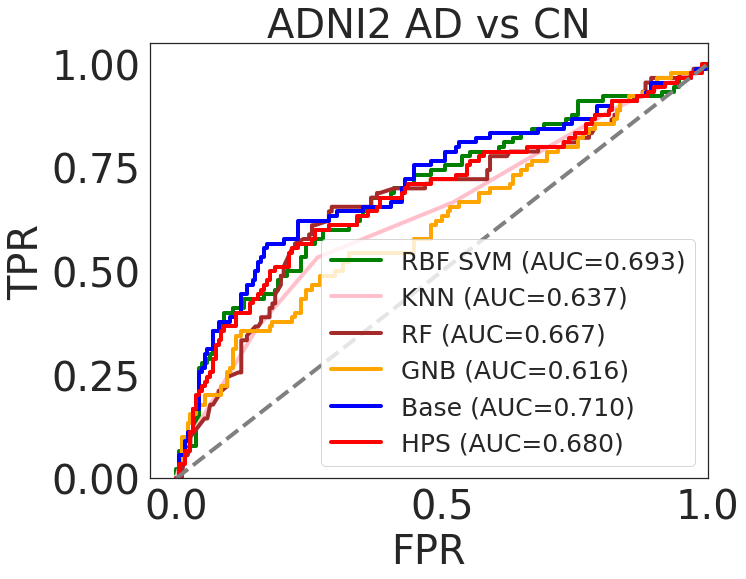

In [78]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
lw = 4
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.plot(fpr_svcrbf[0], tpr_svcrbf[0], color='green',
         lw=lw, label='RBF SVM (AUC=%0.3f)' % roc_auc_svcrbf[0])
plt.plot(fpr_knn[0], tpr_knn[0], color='pink',
         lw=lw, label='KNN (AUC=%0.3f)' % roc_auc_knn[0])
plt.plot(fpr_rf[0], tpr_rf[0], color='brown',
         lw=lw, label='RF (AUC=%0.3f)' % roc_auc_rf[0])
plt.plot(fpr_nb[0], tpr_nb[0], color='orange',
         lw=lw, label='GNB (AUC=%0.3f)' % roc_auc_nb[0])
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (AUC=%0.3f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (AUC=%0.3f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontdict={'size': 40})
plt.ylabel('TPR', fontdict={'size': 40})
plt.title('ADNI2 AD vs CN', fontdict={'size': 40})
plt.legend(loc="lower right", prop={'size': 25})
#ax.legend(loc='center left', bbox_to_anchor=(1,0.5), prop={'size': 30})
plt.show()
fig.savefig(path_results + 'adni2_ad_roc_multi.pdf', bbox_inches='tight')

## MCI stable vs converters

In [79]:
adni2_mci = pd.read_csv('/home/angela/Desktop/vcog_paper/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_mci_bl_demog_weights.csv')

In [80]:
mask_mci = adni2_mci.loc[:,'MCI'].values.astype(bool)
adni2_mci = adni2_mci.iloc[mask_mci]

In [81]:
adni2_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv'],inplace=True)

In [82]:
x_ = adni2_mci.iloc[:, adni2_mci.columns.get_loc("sub1"):adni2_mci.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_mci[['conv_2_ad']].values.ravel()


confounds = adni2_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((237, 11), (237,), (237, 4))

In [83]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  55.0
# true values:  237
ACC  :  0.759493670886076
Level 2
------------------------
Ratio: 0.4727272727272727
#    :  26.0
# true values:  44
ACC  :  0.5909090909090909


In [84]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [85]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  55.0
Total number of NON-TARGET subjects:  182.0
Stage 1 number of hits (true and false positives):  76.0
Stage 1 TRUE positives:  37.0
Stage 1 FALSE positives:  39.0
Stage 1 TRUE negatives:  143.0
Total number of flagged HPC-AD subjects:  44.0
Number of flagged HPC-AD subjects that are TRUE positives:  26
Number of flagged HPC-AD subjects that are FALSE positives:  18.0
Number of true negatives:  164.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.4868421052631579
Recall (or sensitivity)  for AD:  0.6727272727272727
Specificity:  0.7857142857142857
Adjusted precision for 33.6% baseline rate:  0.6136921384446137
Accuracy:  0.759493670886076
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.5909090909090909
Recall (or sensitivity) for HPC-AD:  0.4727272727272727
Specificity:  0.9010989010989011
Adjusted precision for 33.6% baseline rate:  0.7074905487088575
Accuracy:

(0.6727272727272727,
 0.7857142857142857,
 0.4868421052631579,
 0.759493670886076,
 0.4727272727272727,
 0.9010989010989011,
 0.5909090909090909,
 0.8016877637130801)

## ROC curve

### base

In [86]:
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(237,)

In [87]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [88]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.54


### HPS 

In [89]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [90]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [91]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.56


### rbf kernel svm

In [92]:
y_predicted = grclf_svm.predict(x_)
y_score = grclf_svm.decision_function(x_)
y_score.shape

(237,)

In [93]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_svcrbf = dict()
tpr_svcrbf = dict()
roc_auc_svcrbf = dict()
for i in range(n_classes):
    fpr_svcrbf[i], tpr_svcrbf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_svcrbf[i] = auc(fpr_svcrbf[i], tpr_svcrbf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_svcrbf["micro"], tpr_svcrbf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_svcrbf["micro"] = auc(fpr_svcrbf["micro"], tpr_svcrbf["micro"])

### k nearest neighbours

In [94]:
y_predicted = grclf_knn.predict(x_)
y_score = grclf_knn.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(237,)

In [95]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(n_classes):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
# Compute micro-average ROC curve and ROC area
fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

### random forest

In [96]:
y_predicted = grclf_rf.predict(x_)
y_score = grclf_rf.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(237,)

In [97]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
# Compute micro-average ROC curve and ROC area
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

### gaussian naive bayes

In [98]:
y_predicted = clf_gnb.predict(x_)
y_score = clf_gnb.predict_proba(x_)
y_score = y_score[:,1] # take positive class
y_score.shape

(237,)

In [99]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_nb = dict()
tpr_nb = dict()
roc_auc_nb = dict()
for i in range(n_classes):
    fpr_nb[i], tpr_nb[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_nb[i] = auc(fpr_nb[i], tpr_nb[i])
    
# Compute micro-average ROC curve and ROC area
fpr_nb["micro"], tpr_nb["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_nb["micro"] = auc(fpr_nb["micro"], tpr_nb["micro"])

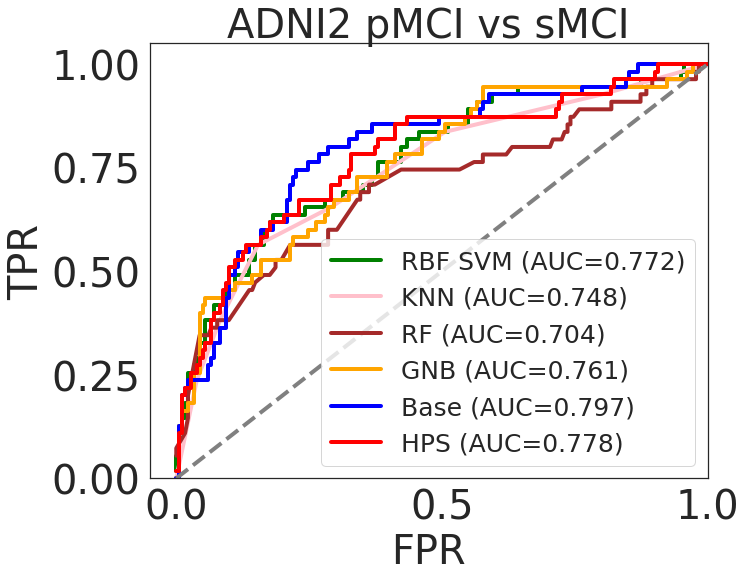

In [100]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
lw = 4
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.plot(fpr_svcrbf[0], tpr_svcrbf[0], color='green',
         lw=lw, label='RBF SVM (AUC=%0.3f)' % roc_auc_svcrbf[0])
plt.plot(fpr_knn[0], tpr_knn[0], color='pink',
         lw=lw, label='KNN (AUC=%0.3f)' % roc_auc_knn[0])
plt.plot(fpr_rf[0], tpr_rf[0], color='brown',
         lw=lw, label='RF (AUC=%0.3f)' % roc_auc_rf[0])
plt.plot(fpr_nb[0], tpr_nb[0], color='orange',
         lw=lw, label='GNB (AUC=%0.3f)' % roc_auc_nb[0])
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (AUC=%0.3f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (AUC=%0.3f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR', fontdict={'size': 40})
plt.ylabel('TPR', fontdict={'size': 40})
plt.title('ADNI2 pMCI vs sMCI', fontdict={'size': 40})
plt.legend(loc="lower right", prop={'size': 25})
#ax.legend(loc='center left', bbox_to_anchor=(1,0.5), prop={'size': 30})
plt.show()
fig.savefig(path_results + 'adni2_mci_roc_multi.pdf', bbox_inches='tight')